In [1]:
### Analyze Meteorological Station Data using LCD data
### Data from Denver International Airport (1995-present)
### https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:03017/detail
### data munged by LCD_munge_Denver_WBAN03017_multiple.ipynb
### Coded by Prof. Kay (University of Colorado)
### Last updated October 7, 2024

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy.cluster.vq import vq, kmeans, whiten
import matplotlib.pyplot as plt

In [3]:
### Read in your data
df1 = pd.read_csv("WBAN03017_1995-2015_hourlydata_munged_wthmissing.csv")
df2 = pd.read_csv("WBAN03017_2015-2024_hourlydata_munged_wthmissing.csv")
df = pd.concat([df1,df2])

### Preview the values in the data frame by printing it
print(df)
### Print the Shape of the data frame
print(df.shape)

                       DATE             datetime  drytemp_F  dewtemp_F  \
0       1995-07-01T00:00:00  1995-07-01 00:00:00       48.0       48.0   
1       1995-07-01T01:00:00  1995-07-01 01:00:00       46.0       46.0   
2       1995-07-01T02:00:00  1995-07-01 02:00:00       46.0       46.0   
3       1995-07-01T03:00:00  1995-07-01 03:00:00       50.0       49.0   
4       1995-07-01T03:12:00  1995-07-01 03:12:00       50.0       49.0   
...                     ...                  ...        ...        ...   
127512  2024-09-30T22:53:00  2024-09-30 22:53:00       51.0       24.0   
127513  2024-09-30T23:00:00  2024-09-30 23:00:00       51.0       24.0   
127514  2024-09-30T23:53:00  2024-09-30 23:53:00       48.0       22.0   
127515  2024-09-30T23:59:00  2024-09-30 23:59:00        NaN        NaN   
127516  2024-09-30T23:59:00  2024-09-30 23:59:00        NaN        NaN   

        prec_inch     RH  pres_mbar   wdir  wspd_mph  wgust_mph  
0             0.0  100.0  840.16300  140.0   

In [4]:
### subset data (if wanted)
#df = df.loc[(df['datetime'] >= '1995-08-01')
#                     & (df['datetime'] < '2024-06-30')]
#df

In [4]:
df

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph
0,1995-07-01T00:00:00,1995-07-01 00:00:00,48.0,48.0,0.0,100.0,840.16300,140.0,5.0,NaN
1,1995-07-01T01:00:00,1995-07-01 01:00:00,46.0,46.0,0.0,100.0,836.77660,150.0,6.0,NaN
2,1995-07-01T02:00:00,1995-07-01 02:00:00,46.0,46.0,0.0,100.0,836.43805,170.0,6.0,NaN
3,1995-07-01T03:00:00,1995-07-01 03:00:00,50.0,49.0,0.0,96.0,836.43805,240.0,6.0,NaN
4,1995-07-01T03:12:00,1995-07-01 03:12:00,50.0,49.0,NaN,96.0,836.43805,240.0,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...
127512,2024-09-30T22:53:00,2024-09-30 22:53:00,51.0,24.0,0.0,35.0,845.24260,0.0,0.0,NaN
127513,2024-09-30T23:00:00,2024-09-30 23:00:00,51.0,24.0,NaN,35.0,846.93585,0.0,0.0,NaN
127514,2024-09-30T23:53:00,2024-09-30 23:53:00,48.0,22.0,0.0,36.0,845.24260,40.0,6.0,NaN
127515,2024-09-30T23:59:00,2024-09-30 23:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Index by pandas datetime
df = df.set_index(pd.to_datetime(df.datetime))
df['month']=pd.DatetimeIndex(df['datetime']).month
df['year']=pd.DatetimeIndex(df['datetime']).year
#df

In [6]:
## Only keep variables of interest
included_cols = ['month','year','drytemp_F'] 
data = df.loc[:, df.columns.isin(list(included_cols))]
## convert to a numpy array
#df_select = df_select.to_numpy()
print(data.shape)
data

(367306, 3)


,drytemp_F,month,year
datetime,,,
1995-07-01 00:00:00,48.0,7,1995
1995-07-01 01:00:00,46.0,7,1995
1995-07-01 02:00:00,46.0,7,1995
1995-07-01 03:00:00,50.0,7,1995
1995-07-01 03:12:00,50.0,7,1995
...,...,...,...
2024-09-30 22:53:00,51.0,9,2024
2024-09-30 23:00:00,51.0,9,2024
2024-09-30 23:53:00,48.0,9,2024


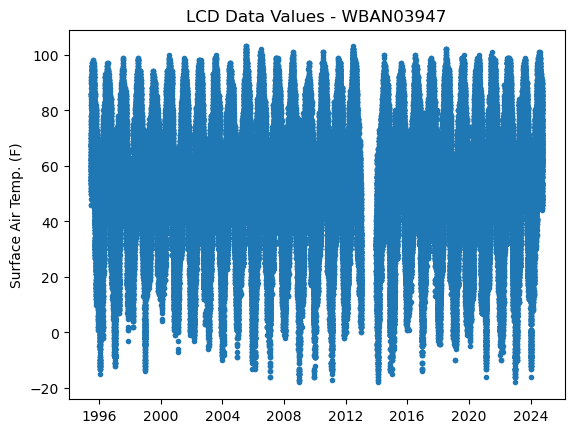

In [7]:
quickplot='yes'
if quickplot == 'yes':
    plt.plot(data['drytemp_F'],'.');
    plt.ylabel('Surface Air Temp. (F)')
    plt.title('LCD Data Values - WBAN03947')
    #plt.xlim(1990,2024)
    plt.show()

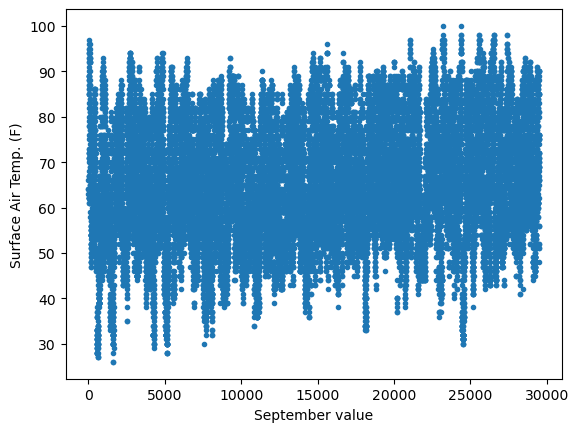

In [8]:
## subset to just winter to make a quicklook of DJF data
plot_data = data.loc[(df['month'] == 9)]
plt.plot(plot_data['drytemp_F'].values,'.');
plt.ylabel('Surface Air Temp. (F)');
plt.xlabel('September value');

In [9]:
print(plot_data.groupby('year').min())
print(plot_data.groupby('year').mean())
print(plot_data.groupby('year').max())

      drytemp_F  month
year                  
1995       27.0      9
1996       26.0      9
1997       35.0      9
1998       44.0      9
1999       29.0      9
2000       28.0      9
2001       39.0      9
2002       38.0      9
2003       30.0      9
2004       38.0      9
2005       39.0      9
2006       34.0      9
2007       39.0      9
2008       42.0      9
2009       36.0      9
2010       41.0      9
2011       38.0      9
2012       45.0      9
2014       33.0      9
2015       46.0      9
2016       37.0      9
2017       41.0      9
2018       36.0      9
2019       40.0      9
2020       30.0      9
2021       42.0      9
2022       43.0      9
2023       41.0      9
2024       44.0      9
      drytemp_F  month
year                  
1995  58.685681    9.0
1996  58.639810    9.0
1997  62.497006    9.0
1998  66.543532    9.0
1999  57.300915    9.0
2000  61.477035    9.0
2001  65.240437    9.0
2002  63.314836    9.0
2003  59.143836    9.0
2004  61.735553    9.0
2005  65.94

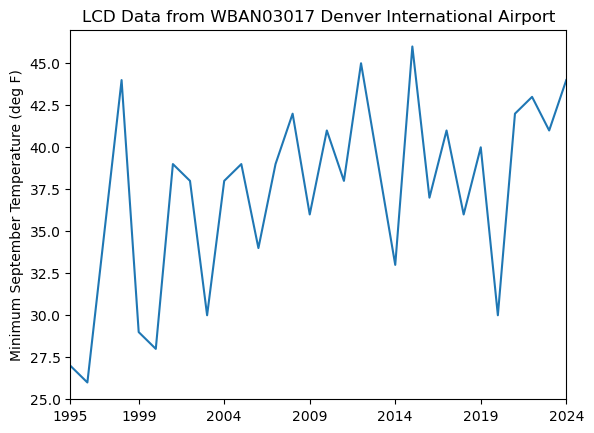

In [31]:
sept_min=plot_data.groupby('year').min()
plt.plot(sept_min['drytemp_F']);
plt.ylabel('Minimum September Temperature (deg F)');
plt.title('LCD Data from WBAN03017 Denver International Airport');
plt.xlim(1995,2024);
xloc=[1995,1999,2004,2009,2014,2019,2024];
plt.xticks(xloc);

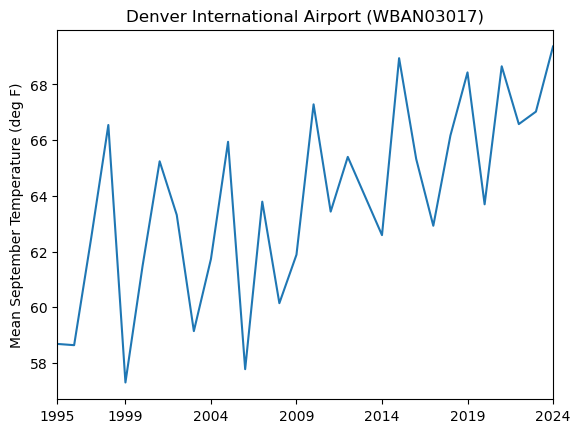

In [34]:
sept_mean=plot_data.groupby('year').mean()
plt.plot(sept_mean['drytemp_F']);
plt.ylabel('Mean September Temperature (deg F)');
plt.title('Denver International Airport (WBAN03017)');
plt.xlim(1995,2024);
xloc=[1995,1999,2004,2009,2014,2019,2024];
plt.xticks(xloc);

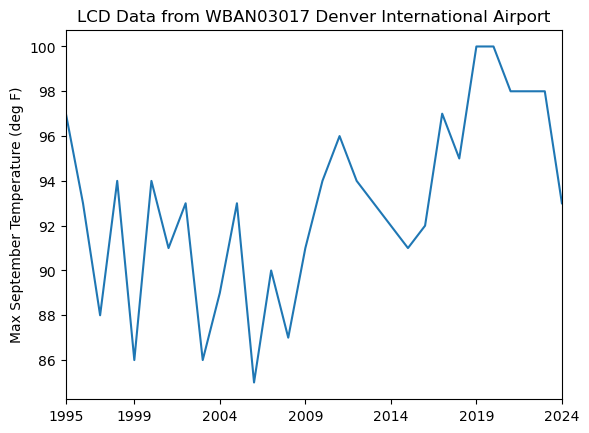

In [33]:
sept_max=plot_data.groupby('year').max()
plt.plot(sept_max['drytemp_F']);
plt.ylabel('Max September Temperature (deg F)');
plt.title('LCD Data from WBAN03017 Denver International Airport');
plt.xlim(1995,2024);
xloc=[1995,1999,2004,2009,2014,2019,2024];
plt.xticks(xloc);

In [13]:
print(np.round(sept_mean['drytemp_F'].mean(),0))
print(np.round(sept_mean['drytemp_F'].min(),0))
print(np.round(sept_mean['drytemp_F'].max(),0))

64.0
57.0
69.0


In [14]:
#### save to CSV

outdata=pd.concat([sept_mean['drytemp_F'], sept_min['drytemp_F'], sept_max['drytemp_F']],axis=1)
outdata.columns = ['meansept_drytemp_degF','minsept_drytemp_degF','maxsept_drytemp_degF']
print(outdata.shape)
print(outdata)

filename='WBAN03017_sept_1995-2024.csv'
outdata.to_csv(filename)

(29, 3)
      meansept_drytemp_degF  minsept_drytemp_degF  maxsept_drytemp_degF
year                                                                   
1995              58.685681                  27.0                  97.0
1996              58.639810                  26.0                  93.0
1997              62.497006                  35.0                  88.0
1998              66.543532                  44.0                  94.0
1999              57.300915                  29.0                  86.0
2000              61.477035                  28.0                  94.0
2001              65.240437                  39.0                  91.0
2002              63.314836                  38.0                  93.0
2003              59.143836                  30.0                  86.0
2004              61.735553                  38.0                  89.0
2005              65.940476                  39.0                  93.0
2006              57.778095                  34.0       